In [1]:
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
import numpy as np
import nltk
import time
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from sklearn.metrics import r2_score

2023-03-09 18:41:11.726354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
wine_df = pd.read_csv('wine_reviews_with_sentiment.csv',index_col= 'Unnamed: 0')

In [3]:
wine_df

,country,description,designation,points,price,province,region_1,region_2,variety,winery,sentiment
Unnamed: 0,,,,,,,,,,,
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,2.240741e-01
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,3.316667e-01
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1.375000e-01
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1.051948e-01
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,8.888889e-02
...,...,...,...,...,...,...,...,...,...,...,...
281809,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),6.000000e-01
281810,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Pinot Noir,Citation,1.387779e-17
281811,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Gewürztraminer,Domaine Gresser,8.750000e-02


# DATA CLEANING PROCESS

In [4]:

wine_df['region_2'] = wine_df['region_2'].fillna('None')

In [5]:
region_counts = wine_df.region_1.value_counts()
region_counts

Napa Valley                       10726
Columbia Valley (WA)               9118
Russian River Valley               6679
California                         6101
Mendoza                            5898
                                  ...  
Benaco Bresciano                      1
Paso Robles Highlands District        1
Vin Pétillant                         1
Vin de Pays de Côtes du Tarn          1
Monterey County-Napa County           1
Name: region_1, Length: 1332, dtype: int64

<Axes: ylabel='Density'>

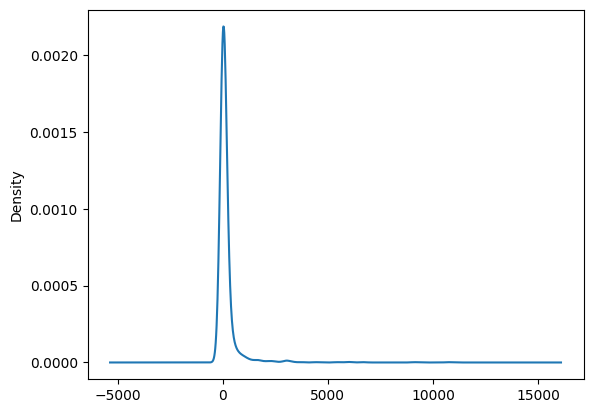

In [6]:
region_counts.plot.density()

In [7]:
region_counts.describe()

count     1332.000000
mean       176.691441
std        637.903257
min          1.000000
25%          5.000000
50%         22.000000
75%         99.250000
max      10726.000000
Name: region_1, dtype: float64

In [8]:
replace_region = list(region_counts[region_counts < 500].index)
replace_region

["Barbera d'Alba",
 'Toro',
 'Pouilly-Fuissé',
 'Arroyo Seco',
 'Eola-Amity Hills',
 'Pomerol',
 'Côtes du Rhône',
 'Barossa',
 'Vino Nobile di Montepulciano',
 'Luján de Cuyo',
 'Saint-Estèphe',
 'Howell Mountain',
 'St. Helena',
 'Etna',
 'Tupungato',
 'Sauternes',
 'Umpqua Valley',
 'Green Valley',
 'Valpolicella Classico Superiore Ripasso',
 'Margaret River',
 'Blaye Côtes de Bordeaux',
 'Saint-Julien',
 'Meursault',
 'Amarone della Valpolicella',
 "Barbera d'Asti",
 'Soave Classico',
 "Montepulciano d'Abruzzo",
 'Jumilla',
 "Vin de Pays d'Oc",
 'Clare Valley',
 'Arroyo Grande Valley',
 'Mount Veeder',
 "Crémant d'Alsace",
 'Beaune',
 'Chianti',
 'Salento',
 'Shenandoah Valley (CA)',
 'Pouilly-Fumé',
 'Veneto',
 'Diamond Mountain District',
 'Valpolicella Superiore Ripasso',
 'Bierzo',
 'Stags Leap District',
 'Prosecco',
 'Cariñena',
 'Campo de Borja',
 'Yarra Valley',
 'Muscadet Sèvre et Maine',
 'Graves',
 'Vin de France',
 'Beaujolais-Villages',
 'Prosecco di Valdobbiadene',
 '

In [9]:
for i in replace_region:
    wine_df.region_1 = wine_df.region_1.replace(i,"Other")

region_counts = wine_df.region_1.value_counts()



<Axes: ylabel='Density'>

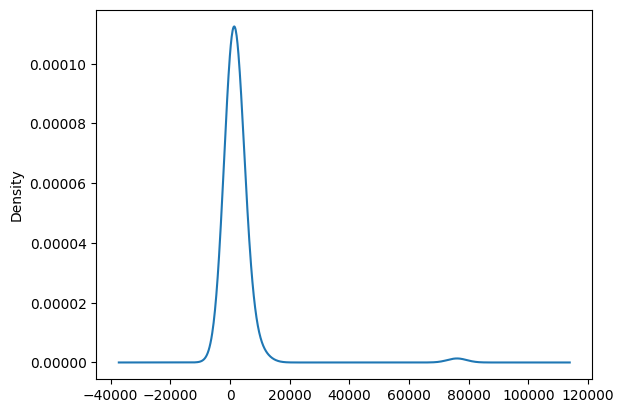

In [10]:
region_counts.plot.density()

In [11]:
winery_counts=wine_df.winery.value_counts()
winery_counts

Williams Selyem          585
Testarossa               495
DFJ Vinhos               473
Chateau Ste. Michelle    420
Wines & Winemakers       392
                        ... 
Namasté Vineyards          1
Finnegan's Lake            1
Villa Yustina              1
Sexual Chocolate           1
Penedo Borges              1
Name: winery, Length: 19186, dtype: int64

<Axes: ylabel='Density'>

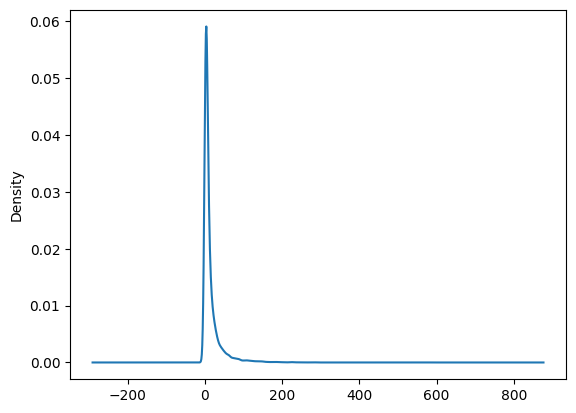

In [12]:
winery_counts.plot.density()

In [13]:
winery_counts.describe()

count    19186.000000
mean        14.688523
std         27.001841
min          1.000000
25%          2.000000
50%          5.000000
75%         15.000000
max        585.000000
Name: winery, dtype: float64

In [14]:
replace_winery = list(winery_counts[winery_counts < 30].index)
replace_winery

['Caldora Vini',
 'Château Kirwan',
 'Château Pichon Longueville Comtesse de Lalande',
 'Château Rahoul',
 'Kaesler',
 'Morgante',
 'Dominio de Atauta',
 'Campelo',
 'Lost Angel',
 'Château Lynch-Bages',
 'Wayfarer',
 'Anne Amie',
 'Belasco de Baquedano',
 'Pope Valley Winery',
 'Tangley Oaks',
 'Nora',
 'Vilafonté',
 'Delamotte',
 'Verbena',
 'Liparita',
 'Calistoga Cellars',
 'Bourassa Vineyards',
 'Langmeil',
 'The Colonial Estate',
 'Heidsieck & Co Monopole',
 'Inception',
 'Cescon Italo Storia e Vini',
 'Château la Gaffelière',
 'Araldica',
 'Estate Constantin Gofas',
 'Vino Con Brio',
 'Brugnano',
 'Carrick',
 'Buitenverwachting',
 'Sacred Hill',
 'Rockroom Winemaking Cooperative',
 'Manzanita Creek',
 'La Valle',
 'Kings Ridge',
 'Musella',
 'Ottimino Vineyards',
 'J. Wilkes',
 'Viñedos y Bodegas Pablo',
 'Cerro Prieto',
 'Huntington',
 'Lanson',
 'Domaine Pommier',
 'Two Angels',
 'Luigi Righetti',
 'Alberti 154',
 'Schwarzböck',
 'Robert Ramsay',
 'Villa Rubini',
 'Domaine de 

In [15]:
for i in replace_winery:
    wine_df.winery = wine_df.winery.replace(i,"Other")

winery_counts = wine_df.winery.value_counts()

In [16]:
winery_counts

Other                    117763
Williams Selyem             585
Testarossa                  495
DFJ Vinhos                  473
Chateau Ste. Michelle       420
                          ...  
Castello del Poggio          30
Fritsch                      30
Domaine Chasselay            30
Sorelle Winery               30
La Folia Winery              30
Name: winery, Length: 2451, dtype: int64

In [17]:
wine_df.dropna(inplace=True)

In [18]:
wine_df = wine_df.drop(columns=['designation'])

In [19]:
word_list = ['full bodied','earthy','savory','herbaceous','minerally','toasty','oaky',
             'spicy','flabby','supple','balanced','sweet','aerated','buttery','fruity']

In [20]:
def check_words(row):
    for word in word_list:
        if word in row:
            return word
    return 'none'

In [21]:
wine_df['adjectives'] = wine_df['description'].apply(check_words)

In [22]:
wine_df = wine_df.drop(columns=['description'])

In [23]:
wine_df.tail()

,country,points,price,province,region_1,region_2,variety,winery,sentiment,adjectives
Unnamed: 0,,,,,,,,,,
281802,France,90,57.0,Alsace,Alsace,None,Pinot Gris,Cave de Turckheim,0.216667,none
281805,Italy,90,40.0,Sicily & Sardinia,Sicilia,None,Nero d'Avola,Cusumano,-0.166667,none
281808,France,90,28.0,Alsace,Alsace,None,Pinot Gris,Domaine Rieflé-Landmann,0.223958,none
281811,France,90,30.0,Alsace,Alsace,None,Gewürztraminer,Domaine Gresser,0.087500,fruity
281813,France,90,21.0,Alsace,Alsace,None,Gewürztraminer,Domaine Schoffit,0.191667,none


In [24]:
for col in wine_df:
    print(wine_df[col].dtype)

object
int64
float64
object
object
object
object
object
float64
object


In [25]:
enc = OneHotEncoder(sparse= False)

In [26]:
for col in wine_df:
    if wine_df[col].dtype == 'object':
        enc_col = wine_df[col]
        wine_df = wine_df.drop(columns=col)
        enc_col2 = pd.DataFrame(enc.fit_transform(enc_col.values.reshape(-1,1)))
        enc_col2.columns = enc.get_feature_names([col])
        wine_df = wine_df.merge(enc_col2,left_index=True,right_index=True)
        
        

/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/l

In [27]:
wine_df.head()

,points,price,sentiment,country_Argentina,country_Australia,country_Canada,country_France,country_Italy,country_Spain,country_US,...,adjectives_full bodied,adjectives_herbaceous,adjectives_minerally,adjectives_none,adjectives_oaky,adjectives_savory,adjectives_spicy,adjectives_supple,adjectives_sweet,adjectives_toasty
0,96,235.0,0.224074,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,96,110.0,0.331667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,96,90.0,0.137500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96,65.0,0.105195,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,95,66.0,0.088889,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
for col in wine_df:
    print(col)

points
price
sentiment
country_Argentina
country_Australia
country_Canada
country_France
country_Italy
country_Spain
country_US
province_Alsace
province_Andalucia
province_Arizona
province_Australia Other
province_Beaujolais
province_Bordeaux
province_British Columbia
province_Burgundy
province_California
province_Canada Other
province_Catalonia
province_Central Italy
province_Central Spain
province_Champagne
province_Colorado
province_Connecticut
province_France Other
province_Galicia
province_Idaho
province_Iowa
province_Italy Other
province_Kentucky
province_Languedoc-Roussillon
province_Levante
province_Loire Valley
province_Lombardy
province_Massachusetts
province_Mendoza Province
province_Michigan
province_Missouri
province_Nevada
province_New Jersey
province_New Mexico
province_New South Wales
province_New York
province_North Carolina
province_Northeastern Italy
province_Northern Spain
province_Northwestern Italy
province_Ohio
province_Ontario
province_Oregon
province_Other
prov

# Creating the Model And Preventing Overfitting

In [29]:
y = wine_df['points']
X = wine_df.drop(columns='points')

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [31]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.fit_transform(X_test)

In [32]:
print(len(X_train_scaled[0]))

1636


In [33]:
number_input_features = len(X_train_scaled[0])
hidden_layers_1 = 750
hidden_layers_list = [250]

nn = tf.keras.models.Sequential()

nn.add(tf.keras.layers.Dense(units=hidden_layers_1, input_dim=number_input_features, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
nn.add(tf.keras.layers.Dropout(0.5))
for i in hidden_layers_list:
    nn.add(tf.keras.layers.Dense(units=i, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    nn.add(tf.keras.layers.Dropout(0.5))

nn.add(tf.keras.layers.Dense(units=1, activation='relu'))





2023-03-09 18:42:53.073117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
checkpoint = ModelCheckpoint('best_weights.h5',save_best_only=True,save_weights_only = True,monitor = 'val_mae',verbose = 1)

In [35]:
nn.compile(loss = 'mae',optimizer ='adam',metrics=['mae'])

In [36]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 750)               1227750   
                                                                 
 dropout (Dropout)           (None, 750)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               187750    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 251       
                                                                 
Total params: 1,415,751
Trainable params: 1,415,751
Non-trainable params: 0
_________________________________________________________________


In [37]:
early_stop = EarlyStopping(monitor='val_mae',patience = 5, verbose = 1)

In [38]:
start_time = time.time()
for i in range(1,82):
    if i >= 60 and i < 72:
        early_stop = EarlyStopping(monitor='val_mae',patience = 3, verbose = 1)
    elif i >= 72:
        early_stop = EarlyStopping(monitor='val_mae',patience = 1, verbose = 1)
    nn.fit(X_train_scaled,y_train,epochs=10000,validation_data=(X_test,y_test),callbacks=[checkpoint,early_stop])
    if i % 2 != 0:
        print(f"loaded Weights {i}")
        nn.load_weights('best_weights.h5')
    else:
        print(f"Random Weights {i}")

end_time = time.time()

Epoch 1/10000
42/50 [========================>.....] - ETA: 0s - loss: 273.4624 - mae: 74.4931
Epoch 1: val_mae improved from inf to 42.67620, saving model to best_weights.h5
50/50 [==============================] - 1s 11ms/step - loss: 250.8903 - mae: 71.9935 - val_loss: 111.2261 - val_mae: 42.6762
Epoch 2/10000
44/50 [=========================>....] - ETA: 0s - loss: 77.2019 - mae: 17.5391
Epoch 2: val_mae did not improve from 42.67620
50/50 [==============================] - 0s 7ms/step - loss: 75.5883 - mae: 16.9678 - val_loss: 93.7079 - val_mae: 43.2262
Epoch 3/10000
43/50 [========================>.....] - ETA: 0s - loss: 62.9412 - mae: 16.1110
Epoch 3: val_mae improved from 42.67620 to 39.27896, saving model to best_weights.h5
50/50 [==============================] - 0s 8ms/step - loss: 62.1632 - mae: 15.7102 - val_loss: 82.8407 - val_mae: 39.2790
Epoch 4/10000
45/50 [==========================>...] - ETA: 0s - loss: 54.6624 - mae: 14.1233
Epoch 4: val_mae did not improve from 3

Epoch 8/10000
49/50 [============================>.] - ETA: 0s - loss: 25.3807 - mae: 7.9959
Epoch 8: val_mae did not improve from 10.24735
50/50 [==============================] - 0s 8ms/step - loss: 25.4101 - mae: 8.0260 - val_loss: 38.5754 - val_mae: 21.1630
Epoch 8: early stopping
Random Weights 2
Epoch 1/10000
44/50 [=========================>....] - ETA: 0s - loss: 25.2346 - mae: 8.1651
Epoch 1: val_mae improved from 10.24735 to 5.12226, saving model to best_weights.h5
50/50 [==============================] - 0s 8ms/step - loss: 25.2177 - mae: 8.1294 - val_loss: 22.1369 - val_mae: 5.1223
Epoch 2/10000
44/50 [=========================>....] - ETA: 0s - loss: 25.7744 - mae: 8.8126
Epoch 2: val_mae did not improve from 5.12226
50/50 [==============================] - 0s 7ms/step - loss: 25.6233 - mae: 8.6456 - val_loss: 34.7628 - val_mae: 17.5962
Epoch 3/10000
46/50 [==========================>...] - ETA: 0s - loss: 25.5811 - mae: 8.6414
Epoch 3: val_mae did not improve from 5.12226

Epoch 4/10000
44/50 [=========================>....] - ETA: 0s - loss: 23.5185 - mae: 7.8261
Epoch 4: val_mae did not improve from 5.12226
50/50 [==============================] - 0s 7ms/step - loss: 23.4224 - mae: 7.7266 - val_loss: 30.2338 - val_mae: 14.5321
Epoch 5/10000
43/50 [========================>.....] - ETA: 0s - loss: 23.2147 - mae: 7.7376
Epoch 5: val_mae did not improve from 5.12226
50/50 [==============================] - 0s 7ms/step - loss: 23.1364 - mae: 7.6286 - val_loss: 41.3132 - val_mae: 25.7699
Epoch 6/10000
44/50 [=========================>....] - ETA: 0s - loss: 22.8457 - mae: 7.5435
Epoch 6: val_mae did not improve from 5.12226
50/50 [==============================] - 0s 7ms/step - loss: 22.9083 - mae: 7.5880 - val_loss: 42.3204 - val_mae: 26.8247
Epoch 7/10000
46/50 [==========================>...] - ETA: 0s - loss: 23.2897 - mae: 7.9534
Epoch 7: val_mae did not improve from 5.12226
50/50 [==============================] - 0s 7ms/step - loss: 23.2668 - mae: 7.

Epoch 10/10000
44/50 [=========================>....] - ETA: 0s - loss: 18.1477 - mae: 6.8005
Epoch 10: val_mae did not improve from 4.24269
50/50 [==============================] - 0s 7ms/step - loss: 18.1609 - mae: 6.8127 - val_loss: 30.4836 - val_mae: 19.1181
Epoch 11/10000
45/50 [==========================>...] - ETA: 0s - loss: 18.4305 - mae: 7.3373
Epoch 11: val_mae did not improve from 4.24269
50/50 [==============================] - 0s 7ms/step - loss: 18.3629 - mae: 7.2520 - val_loss: 20.7494 - val_mae: 9.5740
Epoch 11: early stopping
loaded Weights 9
Epoch 1/10000
45/50 [==========================>...] - ETA: 0s - loss: 22.9603 - mae: 7.7484
Epoch 1: val_mae did not improve from 4.24269
50/50 [==============================] - 0s 8ms/step - loss: 22.9319 - mae: 7.7133 - val_loss: 21.8398 - val_mae: 6.6292
Epoch 2/10000
46/50 [==========================>...] - ETA: 0s - loss: 22.6185 - mae: 7.6484
Epoch 2: val_mae did not improve from 4.24269
50/50 [===========================

Epoch 3/10000
44/50 [=========================>....] - ETA: 0s - loss: 16.2091 - mae: 6.6065
Epoch 3: val_mae did not improve from 2.64150
50/50 [==============================] - 0s 7ms/step - loss: 16.2792 - mae: 6.6230 - val_loss: 18.9491 - val_mae: 8.9354
Epoch 4/10000
46/50 [==========================>...] - ETA: 0s - loss: 16.5138 - mae: 6.8135
Epoch 4: val_mae did not improve from 2.64150
50/50 [==============================] - 0s 7ms/step - loss: 16.5922 - mae: 6.8936 - val_loss: 27.7420 - val_mae: 18.1596
Epoch 5/10000
46/50 [==========================>...] - ETA: 0s - loss: 16.2456 - mae: 6.8182
Epoch 5: val_mae did not improve from 2.64150
50/50 [==============================] - 0s 7ms/step - loss: 16.2153 - mae: 6.7779 - val_loss: 29.5904 - val_mae: 19.9110
Epoch 6/10000
43/50 [========================>.....] - ETA: 0s - loss: 16.3525 - mae: 7.0271
Epoch 6: val_mae did not improve from 2.64150
50/50 [==============================] - 0s 7ms/step - loss: 16.3118 - mae: 7.0

42/50 [========================>.....] - ETA: 0s - loss: 15.6381 - mae: 6.8262
Epoch 13: val_mae improved from 2.64150 to 2.59307, saving model to best_weights.h5
50/50 [==============================] - 0s 8ms/step - loss: 15.6240 - mae: 6.8161 - val_loss: 11.3469 - val_mae: 2.5931
Epoch 14/10000
42/50 [========================>.....] - ETA: 0s - loss: 16.7547 - mae: 7.8944
Epoch 14: val_mae did not improve from 2.59307
50/50 [==============================] - 0s 7ms/step - loss: 16.5647 - mae: 7.7259 - val_loss: 17.4604 - val_mae: 8.7735
Epoch 15/10000
42/50 [========================>.....] - ETA: 0s - loss: 15.0613 - mae: 6.4396
Epoch 15: val_mae did not improve from 2.59307
50/50 [==============================] - 0s 7ms/step - loss: 15.0731 - mae: 6.4687 - val_loss: 16.7480 - val_mae: 8.2625
Epoch 16/10000
44/50 [=========================>....] - ETA: 0s - loss: 14.9357 - mae: 6.6808
Epoch 16: val_mae did not improve from 2.59307
50/50 [==============================] - 0s 8ms/ste

Epoch 6/10000
45/50 [==========================>...] - ETA: 0s - loss: 13.0872 - mae: 6.3778
Epoch 6: val_mae did not improve from 1.90633
50/50 [==============================] - 0s 7ms/step - loss: 13.0798 - mae: 6.3858 - val_loss: 16.0649 - val_mae: 9.5219
Epoch 6: early stopping
Random Weights 18
Epoch 1/10000
46/50 [==========================>...] - ETA: 0s - loss: 12.9567 - mae: 6.6423
Epoch 1: val_mae did not improve from 1.90633
50/50 [==============================] - 0s 8ms/step - loss: 13.1105 - mae: 6.7889 - val_loss: 8.7273 - val_mae: 2.3696
Epoch 2/10000
45/50 [==========================>...] - ETA: 0s - loss: 13.0605 - mae: 6.4513
Epoch 2: val_mae did not improve from 1.90633
50/50 [==============================] - 0s 7ms/step - loss: 13.1125 - mae: 6.4934 - val_loss: 8.7348 - val_mae: 2.0234
Epoch 3/10000
45/50 [==========================>...] - ETA: 0s - loss: 13.0384 - mae: 6.5052
Epoch 3: val_mae did not improve from 1.90633
50/50 [==============================] - 

Epoch 8/10000
42/50 [========================>.....] - ETA: 0s - loss: 11.1090 - mae: 6.1706
Epoch 8: val_mae improved from 1.90633 to 1.65105, saving model to best_weights.h5
50/50 [==============================] - 0s 8ms/step - loss: 11.0649 - mae: 6.1342 - val_loss: 6.4732 - val_mae: 1.6511
Epoch 9/10000
43/50 [========================>.....] - ETA: 0s - loss: 10.9361 - mae: 6.1854
Epoch 9: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 11.0426 - mae: 6.2767 - val_loss: 6.6642 - val_mae: 1.8122
Epoch 10/10000
45/50 [==========================>...] - ETA: 0s - loss: 11.0853 - mae: 6.2327
Epoch 10: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.1823 - mae: 6.2775 - val_loss: 11.5939 - val_mae: 6.2015
Epoch 11/10000
43/50 [========================>.....] - ETA: 0s - loss: 11.2323 - mae: 6.1575
Epoch 11: val_mae did not improve from 1.65105
50/50 [==============================] - 0

Epoch 7: early stopping
Random Weights 24
Epoch 1/10000
44/50 [=========================>....] - ETA: 0s - loss: 10.6872 - mae: 6.1555
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 10.7345 - mae: 6.2308 - val_loss: 12.3927 - val_mae: 8.1558
Epoch 2/10000
44/50 [=========================>....] - ETA: 0s - loss: 10.6316 - mae: 6.3738
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.6578 - mae: 6.4192 - val_loss: 7.5486 - val_mae: 3.5626
Epoch 3/10000
46/50 [==========================>...] - ETA: 0s - loss: 9.8748 - mae: 6.0308
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.8377 - mae: 6.0064 - val_loss: 6.6144 - val_mae: 3.0234
Epoch 4/10000
44/50 [=========================>....] - ETA: 0s - loss: 9.6899 - mae: 6.1622
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 

43/50 [========================>.....] - ETA: 0s - loss: 9.4147 - mae: 6.2956
Epoch 7: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.3472 - mae: 6.2500 - val_loss: 4.7244 - val_mae: 1.8082
Epoch 8/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.3912 - mae: 6.2786
Epoch 8: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.3264 - mae: 6.2153 - val_loss: 6.7785 - val_mae: 3.7696
Epoch 9/10000
46/50 [==========================>...] - ETA: 0s - loss: 9.3989 - mae: 6.3758
Epoch 9: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.4435 - mae: 6.4165 - val_loss: 12.0672 - val_mae: 9.0291
Epoch 10/10000
46/50 [==========================>...] - ETA: 0s - loss: 8.9347 - mae: 6.0122
Epoch 10: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 8.8974 - mae: 5.9889 - val_loss: 10.1900 

43/50 [========================>.....] - ETA: 0s - loss: 18.1306 - mae: 6.6112
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 18.1203 - mae: 6.6543 - val_loss: 12.9764 - val_mae: 2.0682
Epoch 4/10000
46/50 [==========================>...] - ETA: 0s - loss: 16.4723 - mae: 6.5442
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 16.4115 - mae: 6.5319 - val_loss: 19.4326 - val_mae: 10.2526
Epoch 5/10000
46/50 [==========================>...] - ETA: 0s - loss: 14.3117 - mae: 6.2206
Epoch 5: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 14.2361 - mae: 6.2145 - val_loss: 14.1587 - val_mae: 7.1006
Epoch 6/10000
45/50 [==========================>...] - ETA: 0s - loss: 12.6783 - mae: 6.2476
Epoch 6: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 12.6047 - mae: 6.1999 - val_loss:

43/50 [========================>.....] - ETA: 0s - loss: 11.4942 - mae: 6.3315
Epoch 11: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.4953 - mae: 6.3408 - val_loss: 7.5410 - val_mae: 2.5778
Epoch 12/10000
46/50 [==========================>...] - ETA: 0s - loss: 11.2332 - mae: 6.3108
Epoch 12: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.2469 - mae: 6.3374 - val_loss: 6.7433 - val_mae: 2.0444
Epoch 13/10000
46/50 [==========================>...] - ETA: 0s - loss: 10.8235 - mae: 6.3228
Epoch 13: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.8585 - mae: 6.3636 - val_loss: 6.5684 - val_mae: 2.2314
Epoch 14/10000
46/50 [==========================>...] - ETA: 0s - loss: 10.7322 - mae: 6.4050
Epoch 14: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.7557 - mae: 6.4296 - val_lo

50/50 [==============================] - ETA: 0s - loss: 9.1674 - mae: 6.1358
Epoch 8: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 9.1674 - mae: 6.1358 - val_loss: 5.0859 - val_mae: 2.2180
Epoch 8: early stopping
loaded Weights 35
Epoch 1/10000
44/50 [=========================>....] - ETA: 0s - loss: 13.1495 - mae: 6.6349
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 13.4503 - mae: 6.6546 - val_loss: 11.0988 - val_mae: 2.0960
Epoch 2/10000
44/50 [=========================>....] - ETA: 0s - loss: 16.9511 - mae: 6.9538
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 17.0766 - mae: 6.9942 - val_loss: 13.2742 - val_mae: 2.5903
Epoch 3/10000
50/50 [==============================] - ETA: 0s - loss: 16.6825 - mae: 6.6378
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - l

44/50 [=========================>....] - ETA: 0s - loss: 10.8267 - mae: 6.1451
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.8050 - mae: 6.1566 - val_loss: 6.8501 - val_mae: 2.5456
Epoch 4/10000
43/50 [========================>.....] - ETA: 0s - loss: 10.5636 - mae: 6.2672
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 10.6130 - mae: 6.3163 - val_loss: 7.7601 - val_mae: 3.5733
Epoch 5/10000
45/50 [==========================>...] - ETA: 0s - loss: 10.0623 - mae: 6.0438
Epoch 5: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.0762 - mae: 6.0760 - val_loss: 8.3838 - val_mae: 4.6505
Epoch 6/10000
43/50 [========================>.....] - ETA: 0s - loss: 9.8688 - mae: 6.0721
Epoch 6: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.8607 - mae: 6.0459 - val_loss: 7.200

42/50 [========================>.....] - ETA: 0s - loss: 14.9166 - mae: 6.3897
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 14.9549 - mae: 6.4933 - val_loss: 15.3496 - val_mae: 7.3512
Epoch 5/10000
43/50 [========================>.....] - ETA: 0s - loss: 13.9364 - mae: 6.4070
Epoch 5: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 13.8582 - mae: 6.3826 - val_loss: 8.7785 - val_mae: 1.7870
Epoch 6/10000
43/50 [========================>.....] - ETA: 0s - loss: 12.8251 - mae: 6.3878
Epoch 6: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 12.7453 - mae: 6.3634 - val_loss: 12.2329 - val_mae: 6.3873
Epoch 7/10000
43/50 [========================>.....] - ETA: 0s - loss: 11.8934 - mae: 6.4003
Epoch 7: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.8817 - mae: 6.4180 - val_loss: 1

45/50 [==========================>...] - ETA: 0s - loss: 10.2667 - mae: 6.4378
Epoch 10: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.2443 - mae: 6.4151 - val_loss: 7.9773 - val_mae: 4.2361
Epoch 11/10000
44/50 [=========================>....] - ETA: 0s - loss: 10.0531 - mae: 6.3017
Epoch 11: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.9998 - mae: 6.2324 - val_loss: 12.0612 - val_mae: 8.2369
Epoch 12/10000
46/50 [==========================>...] - ETA: 0s - loss: 10.0502 - mae: 6.0364
Epoch 12: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.0593 - mae: 6.0710 - val_loss: 12.5626 - val_mae: 8.9885
Epoch 13/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.6473 - mae: 6.1194
Epoch 13: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.7425 - mae: 6.2098 - val_los

Epoch 2/10000
43/50 [========================>.....] - ETA: 0s - loss: 11.9314 - mae: 6.3384
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.8677 - mae: 6.3396 - val_loss: 12.7866 - val_mae: 7.8643
Epoch 3/10000
43/50 [========================>.....] - ETA: 0s - loss: 11.1052 - mae: 6.3647
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.9429 - mae: 6.2347 - val_loss: 12.1044 - val_mae: 7.7322
Epoch 4/10000
43/50 [========================>.....] - ETA: 0s - loss: 10.4868 - mae: 6.2685
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.4925 - mae: 6.3129 - val_loss: 9.4724 - val_mae: 5.6938
Epoch 5/10000
44/50 [=========================>....] - ETA: 0s - loss: 9.9481 - mae: 6.1820 
Epoch 5: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.8699 - mae: 6.1191 

43/50 [========================>.....] - ETA: 0s - loss: 13.1567 - mae: 6.3804
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 13.6531 - mae: 6.4304 - val_loss: 15.4909 - val_mae: 5.2944
Epoch 2/10000
44/50 [=========================>....] - ETA: 0s - loss: 17.9325 - mae: 6.7425
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 17.9825 - mae: 6.6944 - val_loss: 13.9010 - val_mae: 2.1020
Epoch 3/10000
46/50 [==========================>...] - ETA: 0s - loss: 17.8074 - mae: 6.5567
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 17.6766 - mae: 6.4946 - val_loss: 16.7443 - val_mae: 6.6714
Epoch 4/10000
44/50 [=========================>....] - ETA: 0s - loss: 15.8607 - mae: 6.5549
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 15.8085 - mae: 6.5558 - val_loss: 

43/50 [========================>.....] - ETA: 0s - loss: 10.0096 - mae: 6.3110
Epoch 7: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.9850 - mae: 6.3117 - val_loss: 9.6602 - val_mae: 6.3052
Epoch 7: early stopping
loaded Weights 55
Epoch 1/10000
47/50 [===========================>..] - ETA: 0s - loss: 12.7847 - mae: 6.5069
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 9ms/step - loss: 12.8355 - mae: 6.4438 - val_loss: 12.8928 - val_mae: 4.8668
Epoch 2/10000
44/50 [=========================>....] - ETA: 0s - loss: 15.2791 - mae: 6.4285
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 15.3404 - mae: 6.4014 - val_loss: 13.4915 - val_mae: 4.0253
Epoch 3/10000
44/50 [=========================>....] - ETA: 0s - loss: 15.9921 - mae: 6.4842
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - 

49/50 [============================>.] - ETA: 0s - loss: 9.9791 - mae: 6.0594 
Epoch 13: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 9.9872 - mae: 6.0695 - val_loss: 5.3189 - val_mae: 1.7367
Epoch 14/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.4916 - mae: 6.1103
Epoch 14: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.5007 - mae: 6.1206 - val_loss: 6.4179 - val_mae: 3.2320
Epoch 15/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.4223 - mae: 6.1156
Epoch 15: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.3881 - mae: 6.0725 - val_loss: 6.6526 - val_mae: 3.3795
Epoch 16/10000
45/50 [==========================>...] - ETA: 0s - loss: 9.7524 - mae: 6.2873
Epoch 16: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 9.7249 - mae: 6.2809 - val_loss: 4.9

Epoch 4/10000
42/50 [========================>.....] - ETA: 0s - loss: 11.8684 - mae: 6.1980
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.9008 - mae: 6.2299 - val_loss: 12.6253 - val_mae: 7.1580
Epoch 5/10000
45/50 [==========================>...] - ETA: 0s - loss: 11.4911 - mae: 6.1512
Epoch 5: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 11.4638 - mae: 6.1592 - val_loss: 12.4261 - val_mae: 7.6800
Epoch 5: early stopping
loaded Weights 63
Epoch 1/10000
48/50 [===========================>..] - ETA: 0s - loss: 12.6151 - mae: 6.3490
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 1s 10ms/step - loss: 12.6900 - mae: 6.3579 - val_loss: 21.3998 - val_mae: 13.5980
Epoch 2/10000
48/50 [===========================>..] - ETA: 0s - loss: 15.2631 - mae: 6.7217
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================

Epoch 3/10000
44/50 [=========================>....] - ETA: 0s - loss: 10.8059 - mae: 6.4018
Epoch 3: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.7144 - mae: 6.3341 - val_loss: 6.7564 - val_mae: 2.7640
Epoch 4/10000
43/50 [========================>.....] - ETA: 0s - loss: 10.3012 - mae: 6.1225
Epoch 4: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.3786 - mae: 6.1662 - val_loss: 10.0042 - val_mae: 5.6700
Epoch 5/10000
45/50 [==========================>...] - ETA: 0s - loss: 11.0357 - mae: 6.4010
Epoch 5: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.9774 - mae: 6.3904 - val_loss: 11.7803 - val_mae: 7.8856
Epoch 6/10000
46/50 [==========================>...] - ETA: 0s - loss: 10.4801 - mae: 6.3575
Epoch 6: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 10.4561 - mae: 6.3220

49/50 [============================>.] - ETA: 0s - loss: 13.2984 - mae: 6.5435
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 13.3195 - mae: 6.5583 - val_loss: 9.0833 - val_mae: 2.3152
Epoch 2/10000
43/50 [========================>.....] - ETA: 0s - loss: 12.8768 - mae: 6.5163
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 7ms/step - loss: 12.8633 - mae: 6.5427 - val_loss: 11.3715 - val_mae: 5.5514
Epoch 2: early stopping
loaded Weights 77
Epoch 1/10000
45/50 [==========================>...] - ETA: 0s - loss: 12.4162 - mae: 6.5334
Epoch 1: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - loss: 12.5199 - mae: 6.5296 - val_loss: 9.9242 - val_mae: 3.1024
Epoch 2/10000
45/50 [==========================>...] - ETA: 0s - loss: 13.6758 - mae: 6.4283
Epoch 2: val_mae did not improve from 1.65105
50/50 [==============================] - 0s 8ms/step - 

In [39]:
loss,accuracy = nn.evaluate(X_test,y_test)

13/13 [==============================] - 0s 4ms/step - loss: 6.4732 - mae: 1.6511


In [40]:
total_time = end_time - start_time

print(f'{total_time} seconds')

264.434778213501 seconds


In [41]:
def create_model():
    number_input_features = len(X_train_scaled[0])
    hidden_layers_1 = 750
    hidden_layers_list = [250]

    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(units=hidden_layers_1, input_dim=number_input_features, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(tf.keras.layers.Dropout(0.5))
    for i in hidden_layers_list:
        model.add(tf.keras.layers.Dense(units=i, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    return model


In [42]:
model_best = create_model()

In [43]:
model_best.load_weights('best_weights.h5')

In [44]:
model_best.compile(loss = 'mae',optimizer ='adam',metrics=['mae'])

In [45]:
loss,accuracy = model_best.evaluate(X_test,y_test)

13/13 [==============================] - 0s 3ms/step - loss: 6.4732 - mae: 1.6511


In [46]:
y_pred = model_best.predict(X_test)

13/13 [==============================] - 0s 3ms/step


In [47]:
data = {'Predicted':y_pred.ravel(),
       'Actual':y_test.ravel()}

In [48]:
result = pd.DataFrame(data)

In [49]:
result['Predicted'] = result['Predicted'].round()

In [50]:
result

,Predicted,Actual
0,89.0,88
1,89.0,90
2,90.0,86
3,90.0,90
4,89.0,89
...,...,...
395,89.0,85
396,91.0,91
397,90.0,89
398,90.0,91


In [51]:
counter = 0
for i in range(len(result)):
    if result['Predicted'].iloc[i] == result['Actual'].iloc[i]:
        counter += 1

print(counter)

        

104


In [52]:
r2 = r2_score(y_test,y_pred)
print('R-Squared: ',r2)

R-Squared:  0.14899646550261936


In [53]:
pred_df = pd.read_csv('Prediction_.csv')

In [54]:
pred_df

,country,price,province,region_1,region_2,variety,winery,sentiment
0,US,30,California,Napa Valley,Napa,Chardonnay,Hall,0.224074
1,US,235,Oregon,Oregon,Oregon Other,Pinot Noir,Testarossa,0.224074


In [55]:
for col in pred_df:
    if pred_df[col].dtype == 'object':
        enc_col = pred_df[col]
        pred_df = pred_df.drop(columns=col)
        enc_col2 = pd.DataFrame(enc.fit_transform(enc_col.values.reshape(-1,1)))
        enc_col2.columns = enc.get_feature_names([col])
        pred_df = pred_df.merge(enc_col2,left_index=True,right_index=True)

/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jordanravelo/opt/anaconda3/envs/mlenv/l

In [56]:
missing_columns = list(set(X.columns) - set(pred_df.columns))

# add the missing columns to df2 and fill with zeros
num_columns_to_add = len(missing_columns) # the number of missing columns to add
new_column_names = missing_columns # create column names
zeros_df = pd.DataFrame(0, index=pred_df.index, columns=new_column_names) # create DataFrame with zeros
pred_df_new = pd.concat([pred_df, zeros_df], axis=1) # concatenate the two DataFrames horizontally

In [57]:
pred_df_new

,price,sentiment,country_US,province_California,province_Oregon,region_1_Napa Valley,region_1_Oregon,region_2_Napa,region_2_Oregon Other,variety_Chardonnay,...,winery_Dutton-Goldfield,winery_Fenestra,winery_One Hope,winery_Longoria,winery_Henri Bourgeois,winery_Torii Mor,winery_Resalte,winery_Baglio di Pianetto,winery_Elk Cove,winery_Penfolds
0,30,0.224074,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,235,0.224074,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
pred_df_scaled = X_scaler.fit_transform(pred_df_new)

In [59]:
unique_cols=set(pred_df_new) - set(X_train)

In [60]:
unique_cols

set()

In [61]:
y_pred = model_best.predict(pred_df_scaled)

1/1 [==============================] - 0s 35ms/step


In [62]:
y_pred

array([[88.872475],
       [88.848366]], dtype=float32)